# Kaggle 入门赛：泰坦尼克号之灾练习（1）

参考资料：[Kaggle Titanic 生存预测(Top1.4%)完整代码分享](https://zhuanlan.zhihu.com/p/33733586)

本文在探索性数据分析的时候，大量使用 seaborn 绘制 bar 图：

```python
sns.barplot(x="Sex", y="Survived", data=train, palette='Set3')
```

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and 

In [2]:
train = pd.read_csv('./input/train.csv', dtype={"Age": np.float64})
test = pd.read_csv('./input/test.csv', dtype={"Age": np.float64})

In [3]:
# 去掉难看的警告
import warnings
warnings.filterwarnings('ignore')

In [4]:
PassengerId = test['PassengerId']
all_data = pd.concat([train, test], ignore_index=True)

## 探索性数据分析

即：数据可视化。

### 性别：女性幸存率远高于男性

Percentage of females who survived:74.20
Percentage of males who survived:18.89


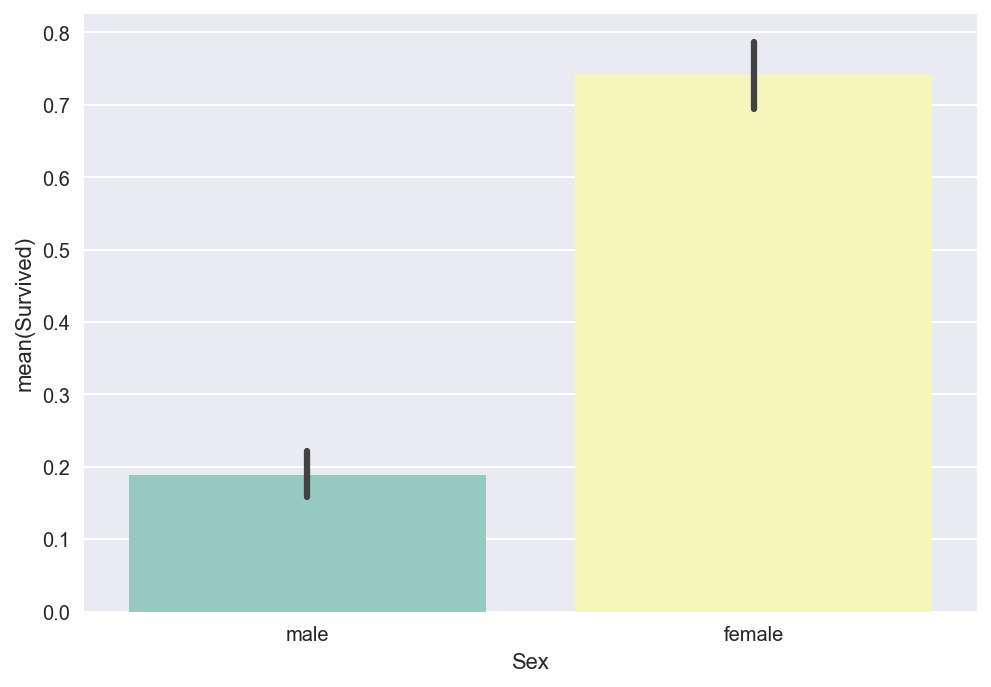

In [5]:
import seaborn as sns

sns.barplot(x="Sex", y="Survived", data=train, palette='Set3')
print("Percentage of females who survived:%.2f" %
      (train["Survived"][train["Sex"] == 'female'].value_counts(
          normalize=True)[1] * 100))
print("Percentage of males who survived:%.2f" %
      (train["Survived"][train["Sex"] == 'male'].value_counts(
          normalize=True)[1] * 100))

### Pclass 乘客社会等级越高，幸存率越高

Percentage of Pclass = 1 who survived:62.96
Percentage of Pclass = 2 who survived:47.28
Percentage of Pclass = 3 who survived:24.24


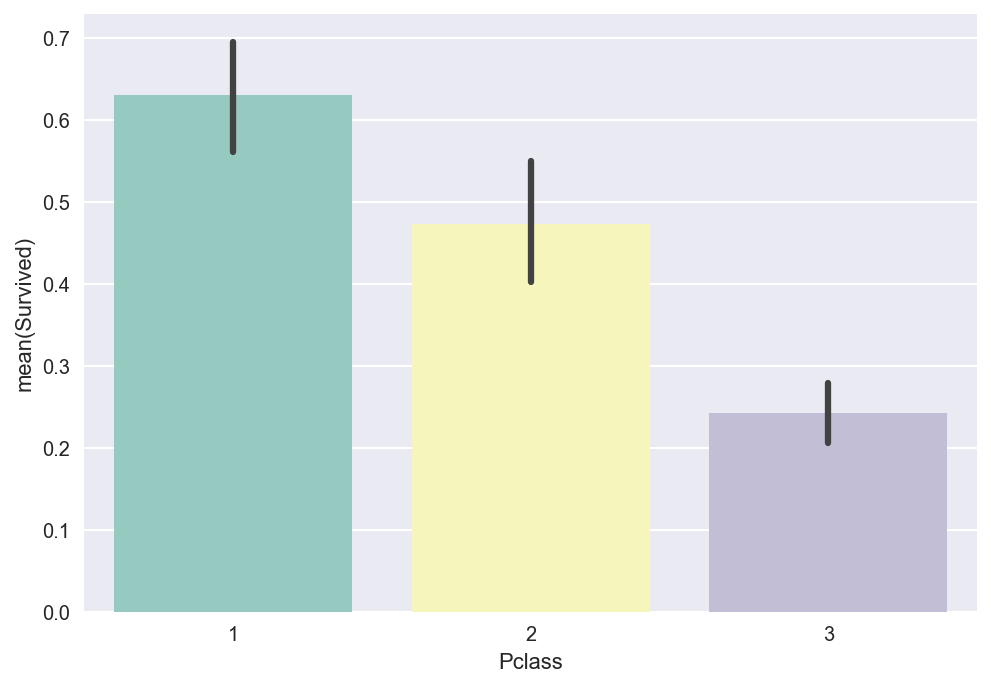

In [6]:
sns.barplot(x="Pclass", y="Survived", data=train, palette='Set3')
print("Percentage of Pclass = 1 who survived:%.2f" %
      (train["Survived"][train["Pclass"] == 1].value_counts(
          normalize=True)[1] * 100))
print("Percentage of Pclass = 2 who survived:%.2f" %
      (train["Survived"][train["Pclass"] == 2].value_counts(
          normalize=True)[1] * 100))
print("Percentage of Pclass = 3 who survived:%.2f" %
      (train["Survived"][train["Pclass"] == 3].value_counts(
          normalize=True)[1] * 100))

### SibSp：配偶及兄弟姐妹数适中的乘客幸存率更高

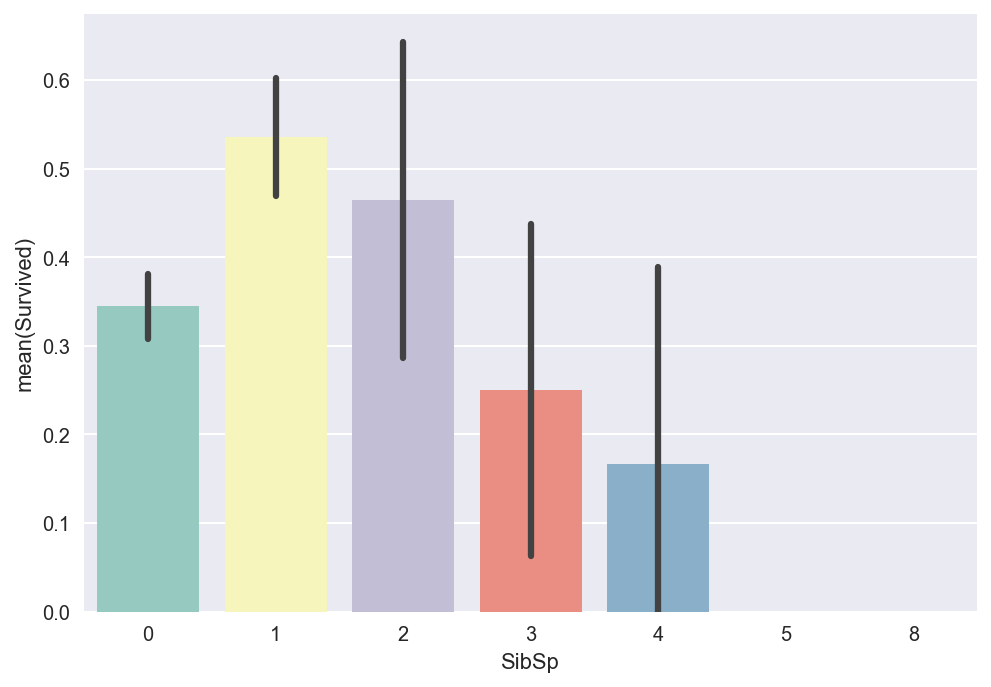

In [7]:
sns.barplot(x="SibSp", y="Survived", data=train, palette='Set3')

### Parch：父母与子女数适中的乘客幸存率更高



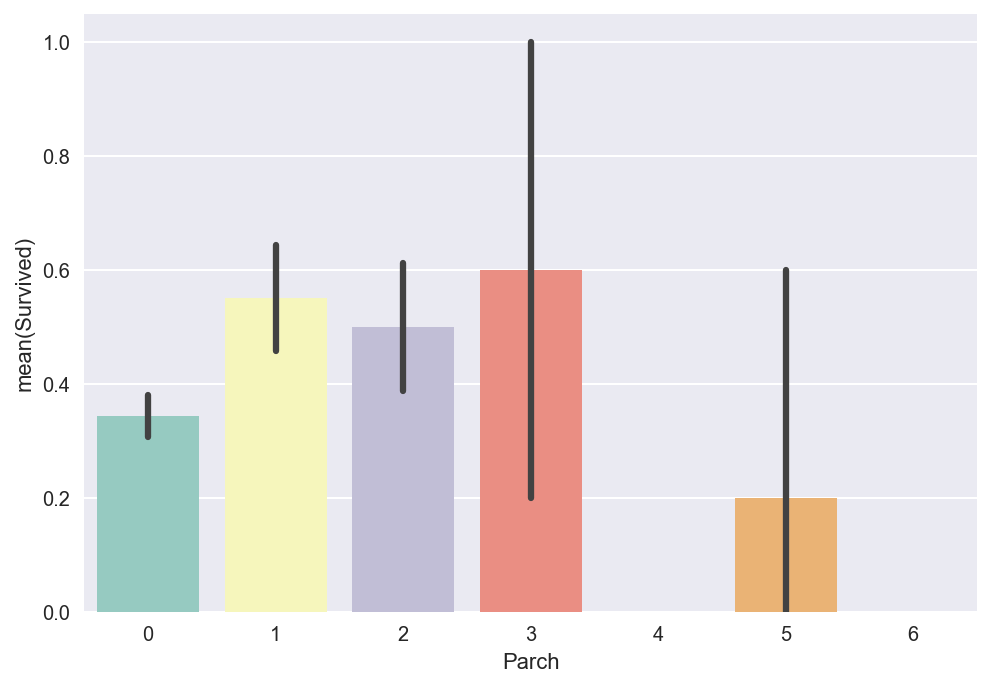

In [8]:
sns.barplot(x="Parch", y="Survived", data=train, palette='Set3')

### Age：未成年人幸存率高于成年人

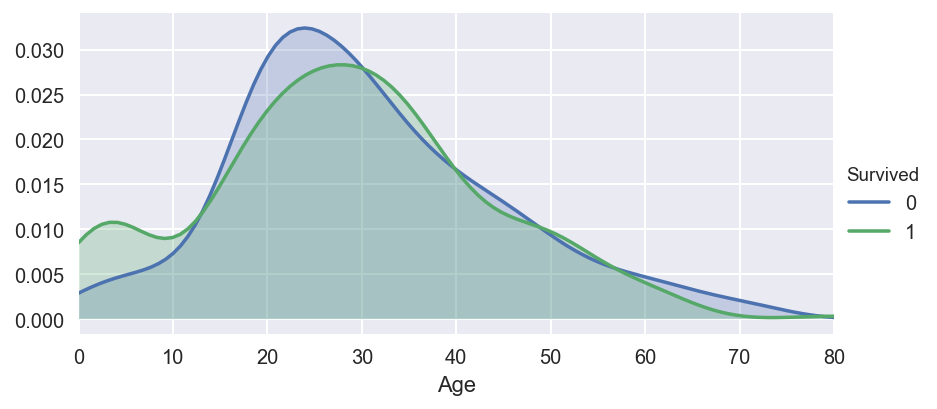

In [9]:
facet = sns.FacetGrid(train, hue="Survived", aspect=2)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

### Fare：支出船票费越高幸存率越高



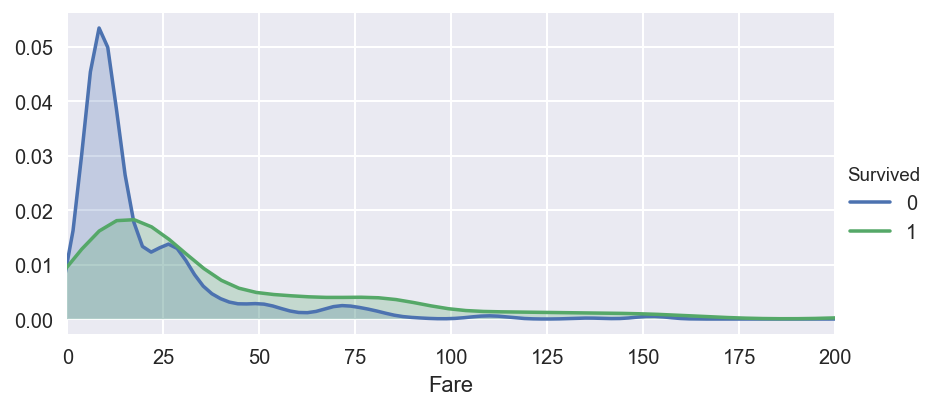

In [10]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 200))
facet.add_legend()

### Title （我们从 Name 中抽取的特征）：不同称呼的乘客幸存率不同

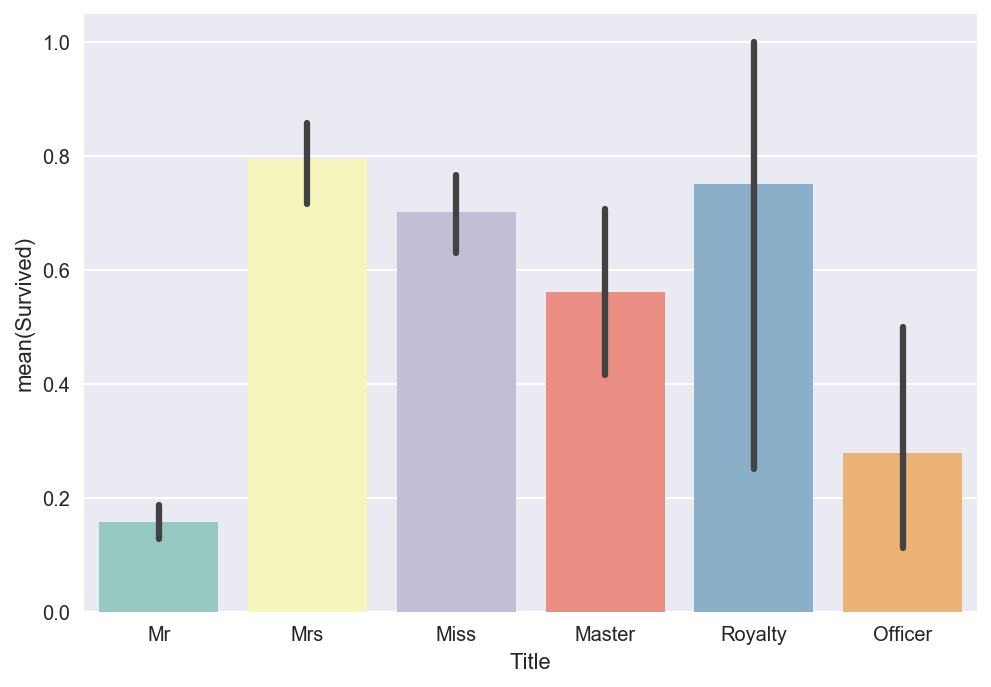

In [11]:
all_data['Title'] = all_data['Name'].apply(
    lambda x: x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(
    dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(
    dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master', 'Jonkheer'], 'Master'))
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x="Title", y="Survived", data=all_data, palette='Set3')

### FamilyLabel（从父母和兄弟人数这两个特征抽取的特征）：家庭人数为2到4的乘客幸存率较高

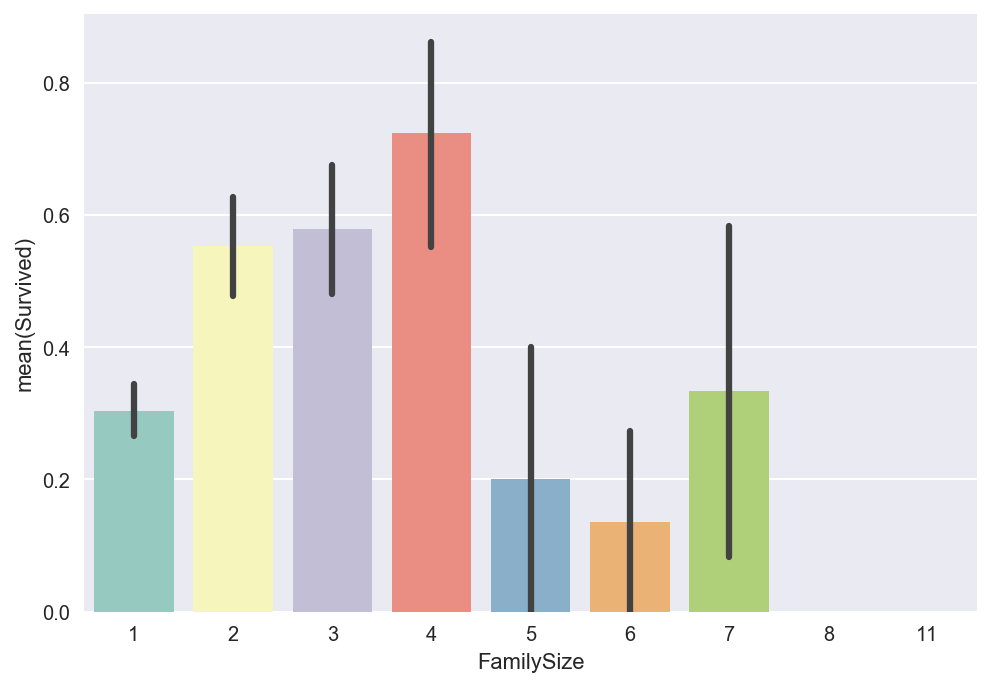

In [12]:
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
sns.barplot(x="FamilySize", y="Survived", data=all_data, palette='Set3')

按生存率把 FamilySize 分为三类，构成 FamilyLabel 特征。

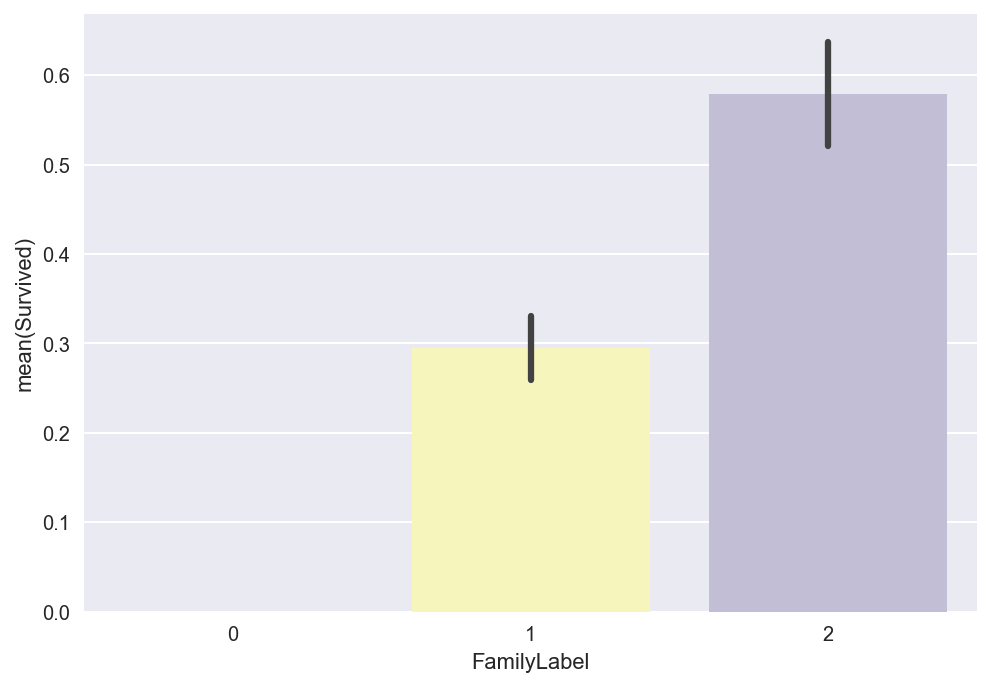

In [13]:
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data, palette='Set3')

### Deck Feature（从 Cabin 中抽取的特征）：不同甲板的乘客幸存率不同

新增 Deck 特征，先把 Cabin 空缺值填充为 'Unknown'，再提取 Cabin 中的首字母构成乘客的甲板号。

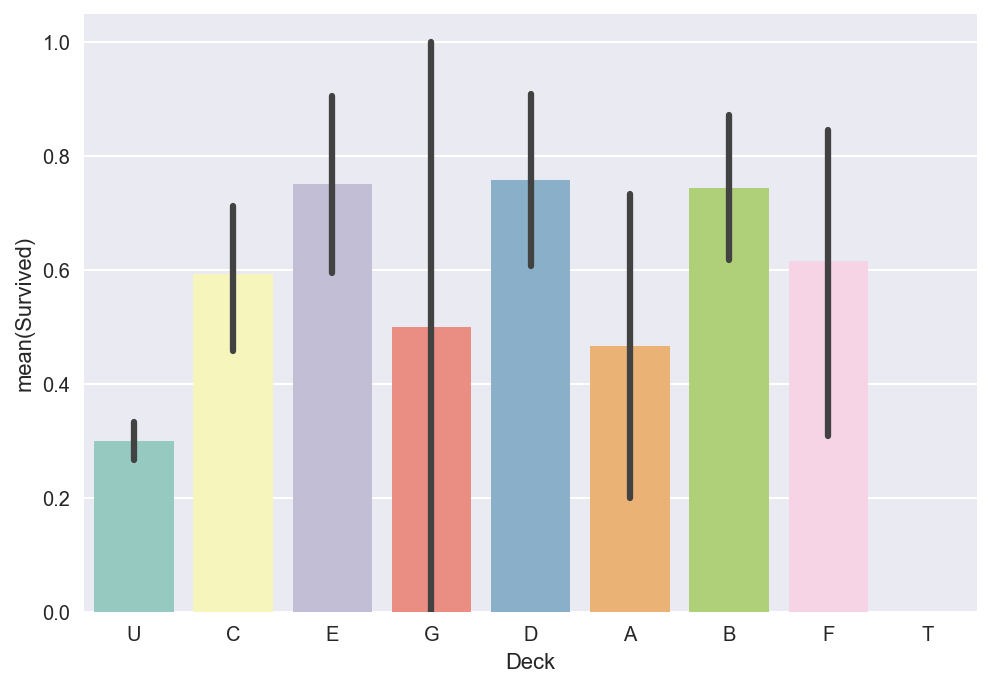

In [14]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data, palette='Set3')

### TicketGroup ：与 2 至 4 人共票号的乘客幸存率较高

新增 TicketGroup 特征，统计每个乘客的共票号数。

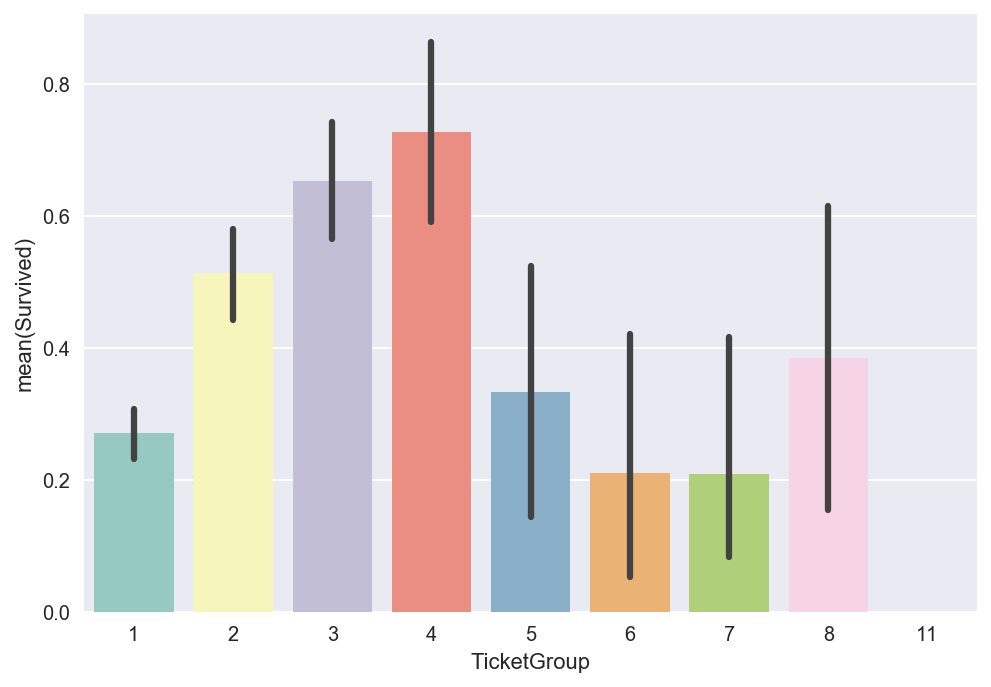

In [15]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x: Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

按生存率把 `TicketGroup` 分为三类。

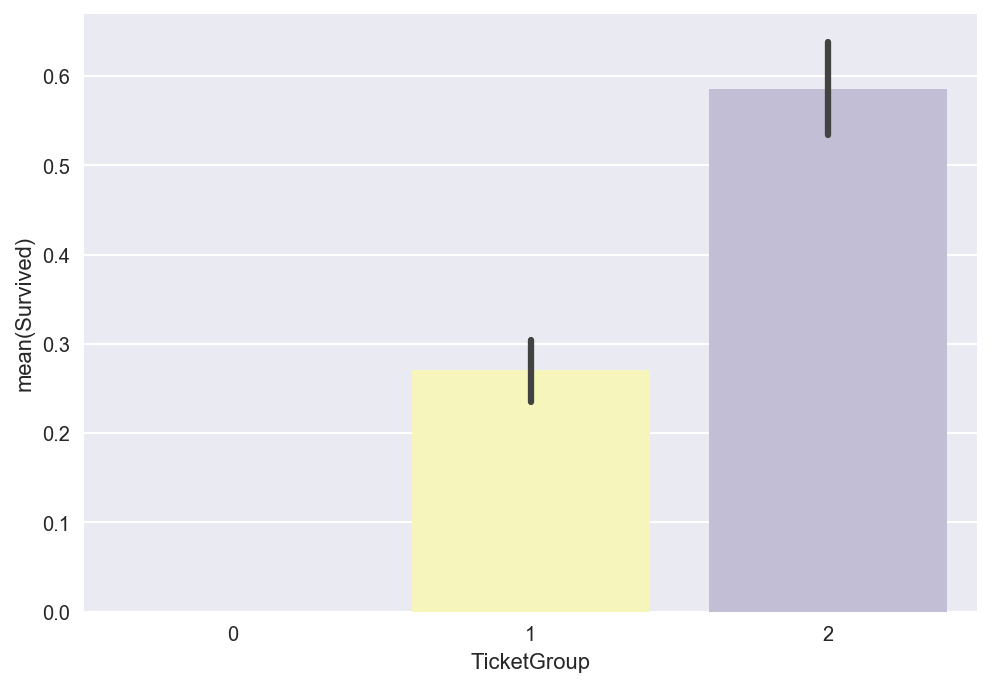

In [16]:
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

## 数据清洗

### 缺失值填充

#### 年龄：用随机森林预测缺失的年龄


Age 缺失量为 263，缺失量较大，用 Sex、Title、Pclass 三个特征构建随机森林模型，填充年龄缺失值。

In [17]:
age_df = all_data[['Age', 'Pclass', 'Sex', 'Title']]
age_df = pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]

In [18]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[(all_data.Age.isnull()), 'Age'] = predictedAges

#### Embarked

<span class="burk">Embarked 缺失量为 2 ，缺失 Embarked 信息的乘客的 Pclass 均为 1 ，且 Fare 均为 80 ，因为 Embarked 为 C 且 Pclass 为 1 的乘客的 Fare 中位数为 80 ，所以缺失值填充为 C。</span>

In [20]:
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,B,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,B,2


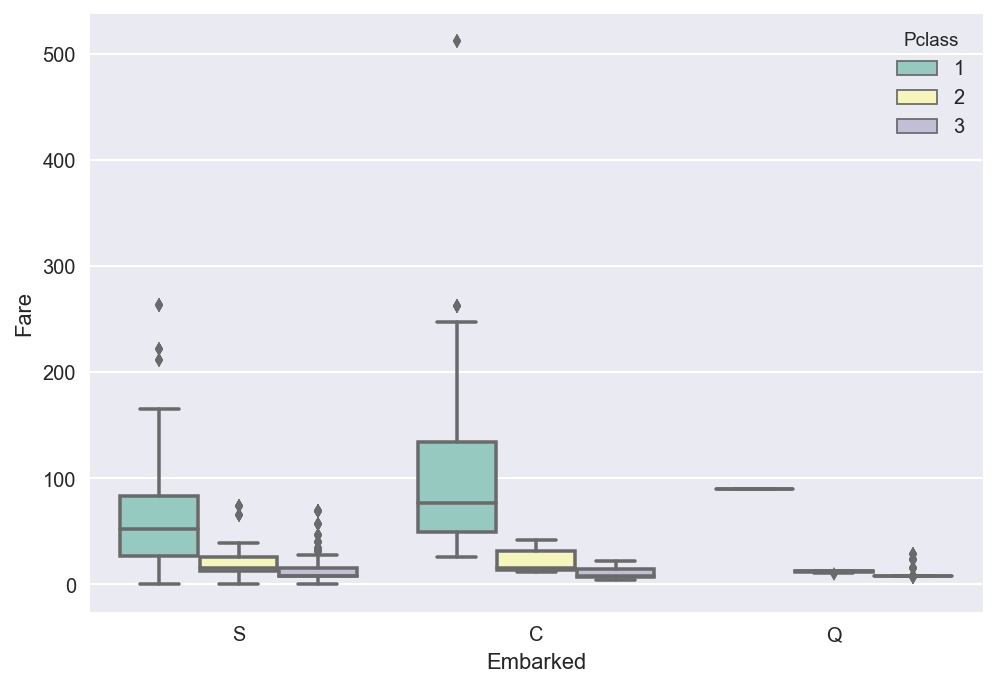

In [21]:
sns.boxplot(
    x="Embarked", y="Fare", hue="Pclass", data=all_data, palette="Set3")

In [22]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

#### Fare 

Fare 缺失量为 1 ，缺失 Fare 信息的乘客的 Embarked 为 S，Pclass 为 3 ，所以用 Embarked 为 S ，Pclass 为 3 的乘客的 Fare 中位数填充。

In [24]:
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,U,1


In [25]:
fare = all_data[(all_data['Embarked'] == "S")
                & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare'] = all_data['Fare'].fillna(fare)

到此为止，我们把缺失值都填补好了。

---

### 同组识别

把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性。

In [26]:
all_data['Surname'] = all_data['Name'].apply(lambda x: x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x: Surname_Count[x])
Female_Child_Group = all_data.loc[(all_data['FamilyGroup'] >= 2) & (
    (all_data['Age'] <= 12) | (all_data['Sex'] == 'female'))]
Male_Adult_Group = all_data.loc[(all_data['FamilyGroup'] >= 2)
                                & (all_data['Age'] > 12) &
                                (all_data['Sex'] == 'male')]

<span class="burk">发现绝大部分女性和儿童组的平均存活率都为 1 或 0 ，即同组的女性和儿童要么全部幸存，要么全部遇难。</span>



In [27]:
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5, 0, 'AverageSurvived')

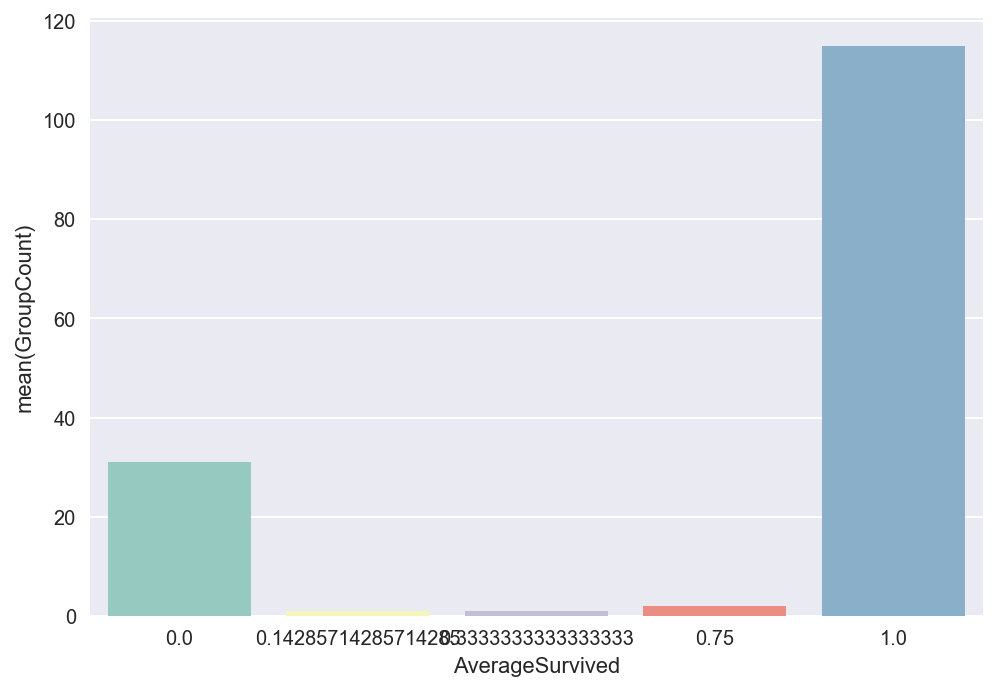

In [28]:
sns.barplot(x=Female_Child.index, y=Female_Child["GroupCount"], palette='Set3').set_xlabel('AverageSurvived')

绝大部分成年男性组的平均存活率也为 1 或 0 。

In [29]:
Male_Adult = pd.DataFrame(
    Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns = ['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


Text(0.5, 0, 'AverageSurvived')

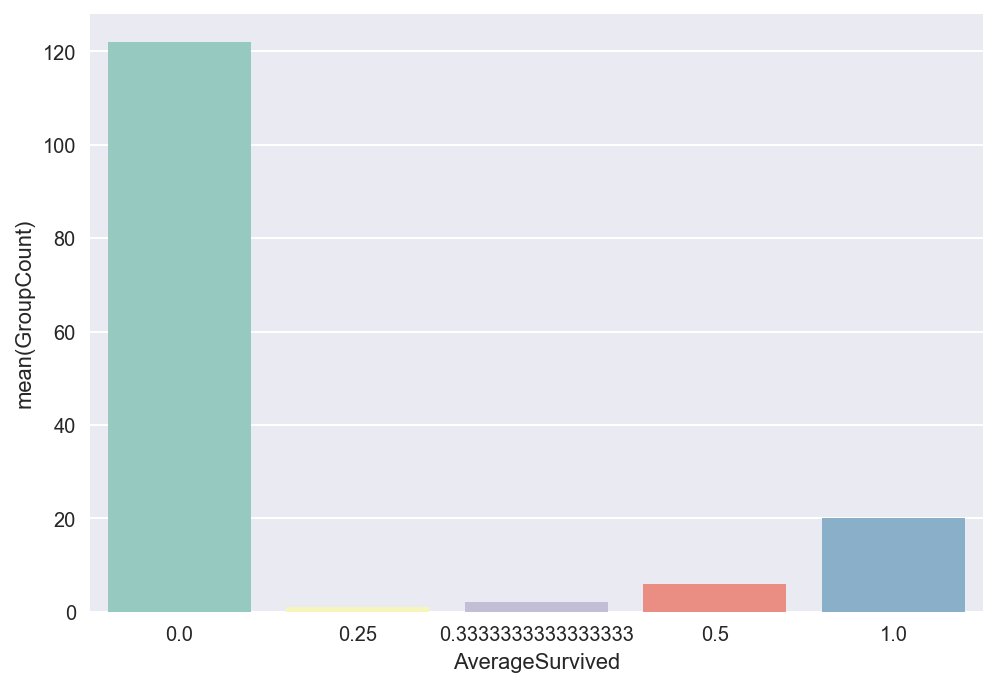

In [30]:
sns.barplot(
    x=Male_Adult.index, y=Male_Adult['GroupCount'],
    palette='Set3').set_xlabel('AverageSurvived')

liwei 注：好厉害啊！
<span class="burk">因为普遍规律是女性和儿童幸存率高，成年男性幸存较低，所以我们把不符合普遍规律的反常组选出来单独处理。把女性和儿童组中幸存率为 0 的组设置为遇难组，把成年男性组中存活率为 1 的设置为幸存组，推测处于遇难组的女性和儿童幸存的可能性较低，处于幸存组的成年男性幸存的可能性较高。</span>

In [31]:
Female_Child_Group = Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List = set(
    Female_Child_Group[Female_Child_Group.apply(lambda x: x == 0)].index)
print(Dead_List)
Male_Adult_List = Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List = set(
    Male_Adult_List[Male_Adult_List.apply(lambda x: x == 1)].index)
print(Survived_List)

{'Goodwin', 'Strom', 'Danbom', 'Zabour', 'Ilmakangas', 'Lahtinen', 'Barbara', 'Rice', 'Caram', 'Lefebre', 'Ford', 'Robins', 'Jussila', 'Canavan', 'Van Impe', 'Bourke', 'Vander Planke', 'Rosblom', 'Boulos', 'Lobb', 'Olsson', 'Turpin', 'Johnston', 'Oreskovic', 'Arnold-Franchi', 'Skoog', 'Attalah', 'Panula', 'Cacic', 'Palsson', 'Sage'}
{'Dick', 'Frauenthal', 'Harder', 'Kimball', 'Chambers', 'Jussila', 'Bradley', 'Greenfield', 'Cardeza', 'Frolicher-Stehli', 'McCoy', 'Nakid', 'Beane', 'Goldenberg', 'Bishop', 'Beckwith', 'Jonsson', 'Taylor', 'Daly', 'Duff Gordon'}


为了使处于这两种反常组中的样本能够被正确分类，对测试集中处于反常组中的样本的 Age、Title、Sex 进行惩罚修改。

In [32]:
train = all_data.loc[all_data['Survived'].notnull()]
test = all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x: x in Dead_List)), 'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x: x in Dead_List)), 'Age'] = 60
test.loc[(test['Surname'].apply(lambda x: x in Dead_List)), 'Title'] = 'Mr'
test.loc[(
    test['Surname'].apply(lambda x: x in Survived_List)), 'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x: x in Survived_List)), 'Age'] = 5
test.loc[(
    test['Surname'].apply(lambda x: x in Survived_List)), 'Title'] = 'Miss'

### 特征转换

选取特征，转换为数值变量，划分训练集和测试集。

In [34]:
all_data = pd.concat([train, test])
all_data = all_data[[
    'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title',
    'FamilyLabel', 'Deck', 'TicketGroup'
]]
all_data = pd.get_dummies(all_data)
train = all_data[all_data['Survived'].notnull()]
test = all_data[all_data['Survived'].isnull()].drop('Survived', axis=1)
X = train.as_matrix()[:, 1:]
y = train.as_matrix()[:, 0]

KeyError: "['Sex' 'Embarked' 'Title' 'Deck'] not in index"

## 建模

### 网格搜索，得到最佳超参数

用网格搜索自动化选取最优参数，事实上我用网格搜索得到的最优参数是 n_estimators=28，max_depth=6。但是参考另一篇 Kernel 把参数改为n_estimators=26，max_depth=6 之后交叉验证分数和 kaggle 评分都有略微提升。

In [35]:
pipe = Pipeline([('select', SelectKBest(k=20)), ('classify',
                                                 RandomForestClassifier(
                                                     random_state=10,
                                                     max_features='sqrt'))])

param_test = {
    'classify__n_estimators': list(range(20, 50, 2)),
    'classify__max_depth': list(range(3, 60, 3))
}
gsearch = GridSearchCV(
    estimator=pipe, param_grid=param_test, scoring='roc_auc', cv=10)
gsearch.fit(X, y)
print(gsearch.best_params_, gsearch.best_score_)

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection

{'classify__max_depth': 6, 'classify__n_estimators': 42} 0.8810963508395343


### 模型训练

In [36]:
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x11b632268>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, ...estimators=26, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

### 交叉验证

In [37]:
cv_score = cross_validation.cross_val_score(pipeline, X, y, cv=10)
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score),
                                                np.std(cv_score)))

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)


CV Score : Mean - 0.8451402 | Std - 0.03276752 


## 预测

In [38]:
predictions = pipeline.predict(test)
submission = pd.DataFrame({
    "PassengerId": PassengerId,
    "Survived": predictions.astype(np.int32)
})
submission.to_csv("submission.csv", index=False)

![](提交结果.jpg)

![](提交排名.jpg)